In [1]:
import gym
import time
import wandb
import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from dataclasses import dataclass
from typing import Any
from random import sample
from matplotlib import pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm 
from collections import deque

from models import Model, ConvModel
from utils import FrameStackingEnv

import matplotlib.pyplot as plt
is_ipython = 'inline' in plt.get_backend()
if is_ipython: from IPython import display
if is_ipython: display.clear_output(wait=True)
    
plt.rcParams['figure.figsize'] = [10, 6]


In [2]:
env = gym.make("Breakout-v0")

In [3]:
env.observation_space, env.action_space

(Box(0, 255, (210, 160, 3), uint8), Discrete(4))

In [4]:
from IPython.display import clear_output

In [5]:
obs = env.reset()


In [6]:
@dataclass
class Sars:
    state: Any
    action: int
    reward: float
    next_state : Any
    done : bool

In [7]:
class ReplayBuffer:
    
    def __init__(self, buffer_size = 100000):   
        self.buffer_size = buffer_size
        self.buffer = [None]*buffer_size
        self.idx = 0
        
    def insert(self, sars):
        self.buffer[self.idx % self.buffer_size] = sars
        self.idx +=1
        
    def sample(self, num_samples):
        assert num_samples < min(self.idx, self.buffer_size)
        if self.idx < self.buffer_size:
            return sample(self.buffer[:self.idx], num_samples)
        return sample(self.buffer, num_samples)

In [8]:
class DQN_Agent:
    
    def __init__(self, env,
                 learning_rate = 1e-4, 
                 discount_rate = 0.99,
                 eps_max = 0.9, 
                 eps_min = 0.01,
                 eps_decay = 1e-6, 
                 boltzman_exploration = False,
                 min_rb_size = int(2e4), 
                 sample_size = 100,
                 model_train_freq = 100,
                 tgt__train_freq = 5000,
                 max_epoch = np.inf, 
                 load_model = None,
                 device = 'cudo:0',
                 name = 'Breakout'):
        
        self.lr = learning_rate
        self.gamma = discount_rate
        self.eps_max = eps_max
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        
        self.boltzman = boltzman_exploration 
        self.min_rb = min_rb_size
        self.sample_size = sample_size 
        self.model_train_freq = model_train_freq 
        self.tgt_train_freq = tgt__train_freq
        self.max_epoch = max_epoch 
        self.chkpt = load_model
        self.device = device
        self.name = name
        
        # init env w/ frame stacking wrapper
        self.env = env #gym.make("Breakout-v0")
        self.env = FrameStackingEnv(self.env, 84, 84, num_stack = 4)  
        
        return
    
    def choose_action(self, eps):
        
        if self.boltzman: # 
                logits = self.m(torch.Tensor(self.last_observation).unsqueeze(0).to(self.device))[0]
                action = torch.distributions.Categorical(logits = logits).sample().item()
        else:
            if np.random.random() < eps: # epsilon greedy
                action = self.env.action_space.sample()
            else:
                action = self.m(torch.Tensor(self.last_observation)
                           .unsqueeze(0).to(self.device)).max(-1)[-1].item()
        return action
    
    def run_episode(self, episode):
        
        # compute decaying exploration rate as a function of episode
        eps = (self.eps_max - self.eps_min) * np.exp(-self.eps_decay*episode) + self.eps_min
        self.last_observation = self.env.reset()
        done = False
        
        rolling_reward = 0
        while not done: # until episode ends
            self.tq.update()

            # choose action
            action = self.choose_action(eps)

            # observe state reward
            obs, reward, done, info = self.env.step(action)
            rolling_reward += reward # sum reward for episode


            self.rb.insert(Sars(self.last_observation, action, reward, obs, done))

            self.last_observation = obs

            self.steps_since_train += 1
            self.step_num += 1

            if self.rb.idx > self.min_rb and self.steps_since_train > self.model_train_freq:

                # train model neural network
                loss = self.train_NN(self.m, 
                                     self.rb.sample(self.sample_size), 
                                     self.tgt,
                                     self.env.action_space.n,
                                     self.device)
                self.steps_since_train = 0 # reset train counter

                wandb.log({'loss': loss.detach().cpu().item(), 
                           'epsilon': eps, 
                           'avg_reward': np.mean(self.episode_rewards[-1])}, 
                          step = self.step_num) # self.step_num
                self.save_reward = np.mean(self.episode_rewards[-1])

                self.epochs_since_tgt_update +=1

                if self.epochs_since_tgt_update > self.tgt_train_freq:
                    self.tgt.load_state_dict(self.m.state_dict())
                    self.epochs_since_tgt_update = 0

                self.epoch += 1
                    
        return rolling_reward # return episode rewards
    
    def train_NN(self, 
                 model,
                 state_transitions, 
                 tgt, 
                 num_actions, 
                 device):
        
        
        curr_states = torch.stack([torch.Tensor(s.state) for s in state_transitions]).to(device)
        rewards = torch.stack([torch.Tensor([s.reward]) for s in state_transitions]).to(device)
        mask = torch.stack([torch.Tensor([0]) if s.done else torch.Tensor([1]) for s in state_transitions]).to(device)
        next_states = torch.stack([torch.Tensor(s.next_state) for s in state_transitions]).to(device)
        actions = [s.action for s in state_transitions]

        with torch.no_grad():
            qvals_next = tgt(next_states).max(-1)[0] #(N, num_actions)

        model.opt.zero_grad()
        qvals = model(curr_states) # (N, num_actins)
        one_hot_actions = F.one_hot(torch.LongTensor(actions), num_actions).to(device)

        #loss = ((rewards + mask[:,0]*qvals_next - torch.sum(qvals * one_hot_actions, -1))**2).mean()

        loss_fn = nn.SmoothL1Loss()
        target = torch.sum(qvals * one_hot_actions, -1)
        inputs = rewards.squeeze() + mask[:,0]*self.gamma*qvals_next
        loss = loss_fn(target, inputs )
        loss.backward()
        model.opt.step()

        return loss
    
    def train(self):
        
        # init w and b for data viz
        wandb.init(project = "DQN_practice", name = self.name)
        
        # init env w/ frame stacking wrapper
        #self.env = gym.make("Breakout-v0")
        #self.env = FrameStackingEnv(self.env, 84, 84, num_stack = 4)       
        
        # instantiate prediction network
        self.m = ConvModel(self.env.observation_space.shape,
                           self.env.action_space.n, lr = self.lr).to(self.device)
        if self.chkpt is not None:
            self.m.load_state_dict(torch.load(self.chkpt))
        
        # instantiate target network
        self.tgt = ConvModel(self.env.observation_space.shape, 
                        self.env.action_space.n, lr = self.lr).to(self.device)
        self.tgt.load_state_dict(self.m.state_dict()) 
        
        # instantiate buffer
        self.rb = ReplayBuffer()
        
        # init counters
        self.epoch = 0
        self.steps_since_train = 0
        self.epochs_since_tgt_update = 0
        self.step_num = -self.min_rb
        self.episode_rewards = []
        episode = 0
        
        self.tq = tqdm()
        try:
            while self.epoch < self.max_epoch:

                self.episode_rewards.append(self.run_episode(episode))
                episode += 1
                clear_output(wait=True)
                
        except KeyboardInterrupt:
            torch.save(self.tgt.state_dict(), 
                   f"models/Breakout_{self.step_num}_{int(self.save_reward)}.pth")
            print('Training Interrupted')
        
    
    def test_episode(self, max_steps = 1000, plot = False, load_model = None):
        
        self.m = ConvModel(self.env.observation_space.shape,
                           self.env.action_space.n, lr = self.lr).to(self.device)
        if load_model is not None:
            self.m.load_state_dict(torch.load(load_model))
            
        frames = []
        obs = self.env.reset()
        frames.append(self.env.frame)
        
        idx = 0
        reward = 0
        done = False
        
        while not done:
            
            action = self.m(torch.Tensor(obs).unsqueeze(0).to(self.device)).max(-1)[-1].item()
            obs, r, done, _ = self.env.step(action)
            reward += r
            frames.append(self.env.frame)
            
            if plot:
                a = self.env.env.render(mode = 'rgb_array')
                plt.figure()
                plt.imshow(a)
                plt.show()
                #time.sleep(0.001)
                clear_output(wait=True)
                
        return reward, np.stack(frames, 0)
    

In [9]:
env = gym.make("Breakout-v0")

In [10]:
env.observation_space.shape

(210, 160, 3)

In [11]:
obs = env.reset()

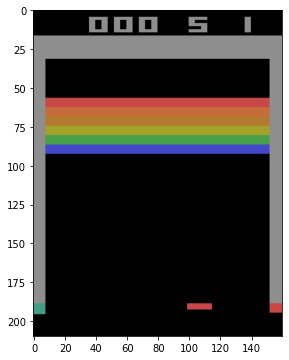

In [12]:
plt.imshow(obs)

In [13]:
obs.shape

(210, 160, 3)

In [14]:
Agent = DQN_Agent(env,
                 learning_rate = 1e-4, 
                 discount_rate = 0.99,
                 eps_max = 0.90, 
                 eps_min = 0.10,
                 eps_decay = 5e-5, 
                 boltzman_exploration = False,
                 min_rb_size = int(5e4), 
                 sample_size = 100,
                 model_train_freq = 100,
                 tgt__train_freq = 5000,
                 max_epoch = np.inf, 
                 load_model = None,#'models/Breakout_4069834_26.pth',
                 device = 'cuda:0',
                 name = 'from_scratch')



In [15]:
Agent.env.observation_space.shape

(4, 84, 84)

In [ ]:
Agent.train()

65042381it [28:27:24, 661.21it/s]

In [27]:
rs = []
for i in range(10):
    r, f = Agent.test_episode(max_steps = 100000, 
                              plot = False, 
                              load_model = 'models/Breakout_1229777_25.pth')
    rs.append(r)
    print(r)

23.0
45.0
111.0
39.0
34.0
79.0
62.0
30.0
62.0
88.0


In [ ]:
print('Average Reward = ', np.mean(rs))

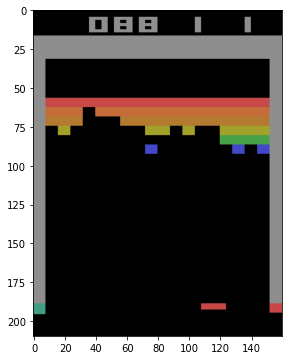

In [28]:
speed = 5 # 5x speed
for im in range(0,len(f), speed):
    plt.imshow(f[im])
    plt.show()
    #time.sleep(0.01)
    clear_output(wait=True)

In [19]:
f[1].shape

(210, 160, 3)